In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import json

In [2]:
# Define the data folder path
folder_path = './data/question_1c'
file_type = ".json"

with open(f'{folder_path}/appliance_params{file_type}', 'r') as f:
    appliance_params = json.load(f)

with open(f'{folder_path}/bus_params{file_type}', 'r') as f:
    bus_params = json.load(f)

with open(f'{folder_path}/consumer_params{file_type}', 'r') as f:
    consumer_params = json.load(f)

with open(f'{folder_path}/DER_production{file_type}', 'r') as f:
    DER_production = json.load(f)

with open(f'{folder_path}/usage_preferences{file_type}', 'r') as f:
    usage_preference = json.load(f)


In [3]:
#System Parameters
bus_data = bus_params[0]
tau_imp = bus_data['import_tariff_DKK/kWh']
tau_exp = bus_data['export_tariff_DKK/kWh']
max_import = bus_data['max_import_kW']
max_export = bus_data['max_export_kW']
electricity_prices = bus_data['energy_price_DKK_per_kWh']

In [4]:
#PV parameters
pv_data = appliance_params['DER'][0]
pv_max_power = pv_data['max_power_kW']
pv_profile = DER_production[0]['hourly_profile_ratio']
pv_prod_hourly = [pv_max_power * ratio for ratio in pv_profile] # PV production per hour (kW) (No curtailment)

In [5]:
#Load parameters
load_data = appliance_params['load'][0]
L_max = load_data['max_load_kWh_per_hour'] # Maximum power consumption (kW)
L_ref_ratio = usage_preference[0]['load_preferences'][0]['hourly_profile_ratio'] # Minimum daily consumption (kWh)
L_ref = [L_max * ratio for ratio in L_ref_ratio] # PV production per hour (kW) (No curtailment)

In [6]:
#Battery parameters
Battery_data = appliance_params['storage'][0]
Battery_preferences = usage_preference[0]['storage_preferences'][0]
Batt_cap = Battery_data['storage_capacity_kWh']
Batt_max_ch_power = Battery_data['max_charging_power_ratio']*Batt_cap
Batt_max_dis_power = Battery_data['max_discharging_power_ratio']*Batt_cap
Batt_charging_eff = Battery_data['charging_efficiency']
Batt_discharging_eff = Battery_data['discharging_efficiency']
Batt_initial_soc = Battery_preferences['initial_soc_ratio']*Batt_cap
Batt_final_soc = Battery_preferences['final_soc_ratio']*Batt_cap

In [7]:
#Temporal parameters
T = len(electricity_prices)  # 24 hours
Times = range(T) # Time horizon (24 hours)
# Discomfort parameter
alpha = 17

In [8]:
model = gp.Model("Energy_Optimization")

# Decision variables:
L_t = model.addVars(Times, lb=0, ub=L_max, name="L_t")  # Load consumption (kW)
C_t = model.addVars(Times, lb=0, name="C_t")  # Energy curtailed from PV (kW)
G_imp_t = model.addVars(Times, lb=0, ub=max_import, name="G_imp_t")  # Grid import (kW)
G_exp_t = model.addVars(Times, lb=0, ub=max_export, name="G_exp_t")  # Grid export (kW)
D_t = model.addVars(Times, lb=0, name="D_t")  # Discomfort (kW)
P_batt_ch = model.addVars(Times, lb=0, ub=Batt_max_ch_power, name="P_batt_ch")  # Battery charging power (kW)
P_batt_dis = model.addVars(Times, lb=0, ub=Batt_max_dis_power, name="P_batt_dis")  # Battery discharging power (kW)
SOC = model.addVars(Times, lb=0, ub=Batt_cap, name="SOC")  # State of Charge (kWh)


# Binary variables for mutual exclusivity of import/export - COMMENTED OUT (LP formulation)
# b_imp_t = model.addVars(Times, vtype=GRB.BINARY, name="b_imp_t")  # 1 if importing, 0 otherwise
# b_exp_t = model.addVars(Times, vtype=GRB.BINARY, name="b_exp_t")  # 1 if exporting, 0 otherwise

# Binary variables for mutual exclusivity of battery charge/discharge - COMMENTED OUT (LP formulation)
# b_ch_t = model.addVars(Times, vtype=GRB.BINARY, name="b_ch_t")  # 1 if charging, 0 otherwise
# b_dis_t = model.addVars(Times, vtype=GRB.BINARY, name="b_dis_t")  # 1 if discharging, 0 otherwise


Set parameter Username
Set parameter LicenseID to value 2670718
Academic license - for non-commercial use only - expires 2026-05-26
Set parameter LicenseID to value 2670718
Academic license - for non-commercial use only - expires 2026-05-26


In [9]:
#Objective function
# Minimize: Import Cost - Export Revenue + Discomfort Penalty
# Import Cost = G_imp * (tau_imp + price)
# Export Revenue = G_exp * (price - tau_exp)
# Discomfort Penalty = alpha * sum(D_t)
model.setObjective(
    gp.quicksum(G_imp_t[t] * (tau_imp + electricity_prices[t]) - 
                G_exp_t[t] * (electricity_prices[t] - tau_exp) for t in Times) + 
    alpha * gp.quicksum(D_t[t] for t in Times),
    GRB.MINIMIZE)

In [ ]:
#add constraints

# Curtailment constraint: Cannot curtail more than PV produces
Curtailment_constraint = [
	model.addLConstr(C_t[t] <= pv_prod_hourly[t], name=f"Curtailment_{t}")
	for t in Times
]

# MILP constraints - COMMENTED OUT (LP formulation)
# Mutual exclusivity: Cannot import and export simultaneously
# Mutual_exclusivity_constraint = [
# 	model.addLConstr(b_imp_t[t] + b_exp_t[t] <= 1, name=f"Mutual_Exclusivity_{t}")
# 	for t in Times
# ]

# Link binary variables to import/export (big-M constraints)
# Import_binary_constraint = [
# 	model.addLConstr(G_imp_t[t] <= max_import * b_imp_t[t], name=f"Import_Binary_{t}")
# 	for t in Times
# ]

# Export_binary_constraint = [
# 	model.addLConstr(G_exp_t[t] <= max_export * b_exp_t[t], name=f"Export_Binary_{t}")
# 	for t in Times
# ]

# Battery MILP constraints - COMMENTED OUT (LP formulation)
# Mutual exclusivity: Cannot charge and discharge simultaneously
# Batt_mutual_exclusivity_constraint = [
# 	model.addLConstr(b_ch_t[t] + b_dis_t[t] <= 1, name=f"Batt_Mutual_Exclusivity_{t}")
# 	for t in Times
# ]

# Link binary variables to battery charge/discharge (big-M constraints)
# Batt_charge_binary_constraint = [
# 	model.addLConstr(P_batt_ch[t] <= Batt_max_ch_power * b_ch_t[t], name=f"Batt_Charge_Binary_{t}")
# 	for t in Times
# ]

# Batt_discharge_binary_constraint = [
# 	model.addLConstr(P_batt_dis[t] <= Batt_max_dis_power * b_dis_t[t], name=f"Batt_Discharge_Binary_{t}")
# 	for t in Times
# ]

# Discomfort constraints: D_t >= |L_t - L_ref[t]|
discomfort_constraint_1 = [
	model.addLConstr(D_t[t] >= L_t[t] - L_ref[t], name=f"discomfort_1_{t}")
	for t in Times
]

discomfort_constraint_2 = [
	model.addLConstr(D_t[t] >= -(L_t[t] - L_ref[t]), name=f"discomfort_2_{t}")
	for t in Times
]

# Power balance constraint
power_balance_constraint = [
	model.addLConstr(G_imp_t[t] - G_exp_t[t] - P_batt_ch[t] + P_batt_dis[t] == L_t[t] - pv_prod_hourly[t] + C_t[t], name=f"power_balance_{t}")
	for t in Times
]

SOC_0 = [
    model.addConstr(SOC[0] == Batt_initial_soc + P_batt_ch[0]*Batt_charging_eff - P_batt_dis[0]/Batt_discharging_eff, name="SOC_0")
]

SOC_dynamics = [
    model.addLConstr(SOC[t] == (SOC[t-1] + P_batt_ch[t]*Batt_charging_eff - P_batt_dis[t]/Batt_discharging_eff), name=f"SOC_dynamics_{t}")
    for t in Times if t > 0
]

SOC_end = [
    model.addLConstr(SOC[T-1] >= Batt_final_soc, name="SOC_end")
]


In [11]:
#solve optimization problem
model.optimize()

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 7 8840HS w/ Radeon 780M Graphics, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 193 rows, 240 columns and 504 nonzeros
Model fingerprint: 0x622e7785
Variable types: 192 continuous, 48 integer (48 binary)
Coefficient statistics:
  Matrix range     [9e-01, 2e+00]

CPU model: AMD Ryzen 7 8840HS w/ Radeon 780M Graphics, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 193 rows, 240 columns and 504 nonzeros
Model fingerprint: 0x622e7785
Variable types: 192 continuous, 48 integer (48 binary)
Coefficient statistics:
  Matrix range     [9e-01, 2e+00]
  Objective range  [4e-01, 2e+01]
  Bounds range     [9e-01, 1e+03]
  RHS range        [1e-01, 3e+00]
Found heuristic solution: objective 464.8404004
  Objective 

In [12]:
#print results
if model.status == GRB.OPTIMAL:
    print("\nOptimal solution found:")
    print(f"Total cost: {model.objVal:.2f} DKK")
    print("Hour | Load (kW) | Curtailment (kW) | Grid Import (kW) | Grid Export (kW) | PV Production (kW) | Electricity Price (DKK/kWh) | State of Charge (kWh) | Battery charging [kW] | Battery discharging [kW]")
    for t in Times:
        print(f"{t:4d} | {L_t[t].X:9.2f} | {C_t[t].X:15.2f} | {G_imp_t[t].X:15.2f} | {G_exp_t[t].X:15.2f} | {pv_prod_hourly[t]:18.2f} | {electricity_prices[t]:25.2f} | {SOC[t].X:18.2f} | {P_batt_ch[t].X:18.2f} | {P_batt_dis[t].X:20.2f}")


Optimal solution found:
Total cost: 18.19 DKK
Hour | Load (kW) | Curtailment (kW) | Grid Import (kW) | Grid Export (kW) | PV Production (kW) | Electricity Price (DKK/kWh) | State of Charge (kWh) | Battery charging [kW] | Battery discharging [kW]
   0 |      0.17 |            0.00 |            0.00 |            0.00 |               0.00 |                      1.10 |               3.15 |               0.17 |                 0.00
   1 |      0.12 |            0.00 |            0.00 |            0.00 |               0.00 |                      1.05 |               3.26 |               0.12 |                 0.00
   2 |      0.12 |            0.00 |            0.00 |            0.00 |               0.00 |                      1.00 |               3.36 |               0.12 |                 0.00
   3 |      0.12 |            0.00 |            1.35 |            0.00 |               0.00 |                      0.90 |               2.00 |               0.00 |                 1.23
   4 |      0

# Part 1.C: Battery Storage Scenarios

**Objective**: Analyze how battery storage impacts energy management across different scenarios

**Scenarios**:
1. **Base Case with Battery** - Normal operation with battery optimization
2. **Reduced PV Generation** - PV production × 0.5 (cloudy day)
3. **High Price Volatility** - Amplified price spread (1.5× deviation from mean)
4. **Zero Grid Tariffs** - Near-zero tariffs for pure arbitrage

**Key Metrics**:
- Total cost comparison (with vs without battery from Part 1.A)
- Battery utilization (SOC profile, charge/discharge patterns)
- Grid import/export reduction
- PV self-consumption improvement

In [ ]:
# Function to run scenario with battery
def run_scenario_with_battery(scenario_name, pv_prod, elec_prices, tau_imp_val, tau_exp_val, 
                               alpha_val, L_ref_input, max_import, max_export, L_max,
                               Batt_cap, Batt_max_ch_power, Batt_max_dis_power, 
                               Batt_charging_eff, Batt_discharging_eff, 
                               Batt_initial_soc, Batt_final_soc):
    """
    Run optimization scenario with battery storage
    """
    model = gp.Model(f"Energy_Optimization_{scenario_name}")
    model.setParam('OutputFlag', 0)
    
    Times = range(len(elec_prices))
    
    # Decision variables
    L_t = model.addVars(Times, lb=0, ub=L_max, name="L_t")
    C_t = model.addVars(Times, lb=0, name="C_t")
    G_imp_t = model.addVars(Times, lb=0, ub=max_import, name="G_imp_t")
    G_exp_t = model.addVars(Times, lb=0, ub=max_export, name="G_exp_t")
    D_t = model.addVars(Times, lb=0, name="D_t")
    P_batt_ch = model.addVars(Times, lb=0, ub=Batt_max_ch_power, name="P_batt_ch")
    P_batt_dis = model.addVars(Times, lb=0, ub=Batt_max_dis_power, name="P_batt_dis")
    SOC = model.addVars(Times, lb=0, ub=Batt_cap, name="SOC")
    
    # Binary variables for battery charge/discharge mutual exclusivity - COMMENTED OUT (LP formulation)
    # b_ch_t = model.addVars(Times, vtype=GRB.BINARY, name="b_ch_t")
    # b_dis_t = model.addVars(Times, vtype=GRB.BINARY, name="b_dis_t")
    
    # Objective function
    model.setObjective(
        gp.quicksum(G_imp_t[t] * (tau_imp_val + elec_prices[t]) - 
                    G_exp_t[t] * (elec_prices[t] - tau_exp_val) for t in Times) + 
        alpha_val * gp.quicksum(D_t[t] for t in Times),
        GRB.MINIMIZE)
    
    # Constraints
    for t in Times:
        model.addLConstr(C_t[t] <= pv_prod[t], name=f"Curtailment_{t}")
        model.addLConstr(D_t[t] >= L_t[t] - L_ref_input[t], name=f"discomfort_1_{t}")
        model.addLConstr(D_t[t] >= -(L_t[t] - L_ref_input[t]), name=f"discomfort_2_{t}")
        model.addLConstr(G_imp_t[t] - G_exp_t[t] + P_batt_ch[t] - P_batt_dis[t] == 
                        L_t[t] - pv_prod[t] + C_t[t], name=f"power_balance_{t}")
        
        # Battery binary constraints - COMMENTED OUT (LP formulation)
        # model.addLConstr(b_ch_t[t] + b_dis_t[t] <= 1, name=f"Batt_Mutual_Exclusivity_{t}")
        # model.addLConstr(P_batt_ch[t] <= Batt_max_ch_power * b_ch_t[t], name=f"Batt_Charge_Binary_{t}")
        # model.addLConstr(P_batt_dis[t] <= Batt_max_dis_power * b_dis_t[t], name=f"Batt_Discharge_Binary_{t}")
    
    # Battery constraints
    model.addConstr(SOC[0] == Batt_initial_soc + P_batt_ch[0]*Batt_charging_eff - 
                   P_batt_dis[0]/Batt_discharging_eff, name="SOC_0")
    
    for t in Times:
        if t > 0:
            model.addLConstr(SOC[t] == SOC[t-1] + P_batt_ch[t]*Batt_charging_eff - 
                           P_batt_dis[t]/Batt_discharging_eff, name=f"SOC_dynamics_{t}")
    
    model.addLConstr(SOC[len(Times)-1] >= Batt_final_soc, name="SOC_end")
    
    # Solve
    model.optimize()
    
    if model.status == GRB.OPTIMAL:
        total_cost = sum(G_imp_t[t].X * (tau_imp_val + elec_prices[t]) - 
                       G_exp_t[t].X * (elec_prices[t] - tau_exp_val) for t in Times)
        total_discomfort = sum(D_t[t].X for t in Times)
        
        return {
            'scenario': scenario_name,
            'total_cost': total_cost,
            'total_discomfort': total_discomfort,
            'objective_value': model.objVal,
            'total_load': sum(L_t[t].X for t in Times),
            'total_import': sum(G_imp_t[t].X for t in Times),
            'total_export': sum(G_exp_t[t].X for t in Times),
            'total_curtailment': sum(C_t[t].X for t in Times),
            'battery_energy_charged': sum(P_batt_ch[t].X for t in Times),
            'battery_energy_discharged': sum(P_batt_dis[t].X for t in Times),
            'load_profile': [L_t[t].X for t in Times],
            'grid_import': [G_imp_t[t].X for t in Times],
            'grid_export': [G_exp_t[t].X for t in Times],
            'curtailment': [C_t[t].X for t in Times],
            'battery_charge': [P_batt_ch[t].X for t in Times],
            'battery_discharge': [P_batt_dis[t].X for t in Times],
            'soc': [SOC[t].X for t in Times]
        }
    else:
        print(f"Warning: No optimal solution for {scenario_name}")
        return None


## Scenario 1: Base Case with Battery

**Description**: Normal operation with battery storage optimization

**Hypothesis**: Battery will reduce costs by storing energy during low-price hours and discharging during high-price hours, while also maximizing PV self-consumption

In [14]:
print("=" * 70)
print("SCENARIO 1: BASE CASE WITH BATTERY")
print("=" * 70)

scenario_1 = run_scenario_with_battery(
    "Base_Case", pv_prod_hourly, electricity_prices, tau_imp, tau_exp, alpha, L_ref,
    max_import, max_export, L_max, Batt_cap, Batt_max_ch_power, Batt_max_dis_power,
    Batt_charging_eff, Batt_discharging_eff, Batt_initial_soc, Batt_final_soc
)

if scenario_1:
    print(f"\n✓ Optimization successful!")
    print(f"Total Cost: {scenario_1['total_cost']:.2f} DKK")
    print(f"Total Discomfort: {scenario_1['total_discomfort']:.2f} kW")
    print(f"Grid Import: {scenario_1['total_import']:.2f} kWh")
    print(f"Grid Export: {scenario_1['total_export']:.2f} kWh")
    print(f"Battery Charged: {scenario_1['battery_energy_charged']:.2f} kWh")
    print(f"Battery Discharged: {scenario_1['battery_energy_discharged']:.2f} kWh")
    print(f"Final SOC: {scenario_1['soc'][-1]:.2f} kWh")
    
    # Check for simultaneous charge/discharge
    simultaneous = sum(1 for t in range(24) if scenario_1['battery_charge'][t] > 0.01 and scenario_1['battery_discharge'][t] > 0.01)
    if simultaneous > 0:
        print(f"\n⚠️ Warning: Simultaneous charge/discharge detected in {simultaneous} hours!")
    else:
        print(f"\n✓ No simultaneous charge/discharge (LP formulation working correctly)")

SCENARIO 1: BASE CASE WITH BATTERY

✓ Optimization successful!
Total Cost: 18.19 DKK
Total Discomfort: 0.00 kW
Grid Import: 11.26 kWh
Grid Export: 1.73 kWh
Battery Charged: 11.78 kWh
Battery Discharged: 6.84 kWh
Final SOC: 6.00 kWh

✓ No simultaneous charge/discharge (LP formulation working correctly)


## Scenario 2: Reduced PV Generation

**Description**: PV production reduced to 50% (cloudy day scenario)

**Hypothesis**: Battery will charge less from PV but still provide arbitrage value by storing low-cost grid energy

In [15]:
print("=" * 70)
print("SCENARIO 2: REDUCED PV GENERATION (50%)")
print("=" * 70)

pv_reduced = [pv * 0.5 for pv in pv_prod_hourly]

scenario_2 = run_scenario_with_battery(
    "Reduced_PV", pv_reduced, electricity_prices, tau_imp, tau_exp, alpha, L_ref,
    max_import, max_export, L_max, Batt_cap, Batt_max_ch_power, Batt_max_dis_power,
    Batt_charging_eff, Batt_discharging_eff, Batt_initial_soc, Batt_final_soc
)

if scenario_2:
    print(f"\n✓ Optimization successful!")
    print(f"Total Cost: {scenario_2['total_cost']:.2f} DKK")
    print(f"Total Discomfort: {scenario_2['total_discomfort']:.2f} kW")
    print(f"Grid Import: {scenario_2['total_import']:.2f} kWh")
    print(f"Grid Export: {scenario_2['total_export']:.2f} kWh")
    print(f"Battery Charged: {scenario_2['battery_energy_charged']:.2f} kWh")
    print(f"Battery Discharged: {scenario_2['battery_energy_discharged']:.2f} kWh")
    print(f"Cost increase vs Base: {scenario_2['total_cost'] - scenario_1['total_cost']:.2f} DKK")

SCENARIO 2: REDUCED PV GENERATION (50%)

✓ Optimization successful!
Total Cost: 29.13 DKK
Total Discomfort: 0.00 kW
Grid Import: 17.28 kWh
Grid Export: 1.10 kWh
Battery Charged: 12.26 kWh
Battery Discharged: 7.23 kWh
Cost increase vs Base: 10.94 DKK

✓ Optimization successful!
Total Cost: 29.13 DKK
Total Discomfort: 0.00 kW
Grid Import: 17.28 kWh
Grid Export: 1.10 kWh
Battery Charged: 12.26 kWh
Battery Discharged: 7.23 kWh
Cost increase vs Base: 10.94 DKK


## Scenario 3: High Price Volatility

**Description**: Amplified price spread - deviations from mean increased by 50%

**Hypothesis**: Greater price spread creates larger arbitrage opportunities, increasing battery value

In [16]:
print("=" * 70)
print("SCENARIO 3: HIGH PRICE VOLATILITY (1.5× deviation)")
print("=" * 70)

# Amplify price spread around mean
p_mean = np.mean(electricity_prices)
prices_volatile = [p_mean + 1.5 * (p - p_mean) for p in electricity_prices]

print(f"Original price range: {min(electricity_prices):.2f} - {max(electricity_prices):.2f} DKK/kWh")
print(f"Volatile price range: {min(prices_volatile):.2f} - {max(prices_volatile):.2f} DKK/kWh")

scenario_3 = run_scenario_with_battery(
    "High_Volatility", pv_prod_hourly, prices_volatile, tau_imp, tau_exp, alpha, L_ref,
    max_import, max_export, L_max, Batt_cap, Batt_max_ch_power, Batt_max_dis_power,
    Batt_charging_eff, Batt_discharging_eff, Batt_initial_soc, Batt_final_soc
)

if scenario_3:
    print(f"\n✓ Optimization successful!")
    print(f"Total Cost: {scenario_3['total_cost']:.2f} DKK")
    print(f"Total Discomfort: {scenario_3['total_discomfort']:.2f} kW")
    print(f"Grid Import: {scenario_3['total_import']:.2f} kWh")
    print(f"Grid Export: {scenario_3['total_export']:.2f} kWh")
    print(f"Battery Charged: {scenario_3['battery_energy_charged']:.2f} kWh")
    print(f"Battery Discharged: {scenario_3['battery_energy_discharged']:.2f} kWh")
    print(f"Cost change vs Base: {scenario_3['total_cost'] - scenario_1['total_cost']:.2f} DKK")

SCENARIO 3: HIGH PRICE VOLATILITY (1.5× deviation)
Original price range: 0.85 - 2.50 DKK/kWh
Volatile price range: 0.62 - 3.09 DKK/kWh

✓ Optimization successful!
Total Cost: 17.70 DKK
Total Discomfort: 0.00 kW
Grid Import: 12.07 kWh
Grid Export: 2.72 kWh
Battery Charged: 12.77 kWh
Battery Discharged: 7.65 kWh
Cost change vs Base: -0.49 DKK


## Scenario 4: Zero Grid Tariffs (Pure Arbitrage)

**Description**: Near-zero import/export tariffs (0.0001 DKK/kWh) for LP stability

**Hypothesis**: Battery becomes pure arbitrage device, maximizing exploitation of price differences

In [17]:
print("=" * 70)
print("SCENARIO 4: ZERO GRID TARIFFS (Pure Arbitrage)")
print("=" * 70)

tau_imp_zero = 0.0001
tau_exp_zero = 0.0001

print(f"Import tariff: {tau_imp_zero:.4f} DKK/kWh (original: {tau_imp:.2f})")
print(f"Export tariff: {tau_exp_zero:.4f} DKK/kWh (original: {tau_exp:.2f})")

scenario_4 = run_scenario_with_battery(
    "Zero_Tariffs", pv_prod_hourly, electricity_prices, tau_imp_zero, tau_exp_zero, alpha, L_ref,
    max_import, max_export, L_max, Batt_cap, Batt_max_ch_power, Batt_max_dis_power,
    Batt_charging_eff, Batt_discharging_eff, Batt_initial_soc, Batt_final_soc
)

if scenario_4:
    print(f"\n✓ Optimization successful!")
    print(f"Total Cost: {scenario_4['total_cost']:.2f} DKK")
    print(f"Total Discomfort: {scenario_4['total_discomfort']:.2f} kW")
    print(f"Grid Import: {scenario_4['total_import']:.2f} kWh")
    print(f"Grid Export: {scenario_4['total_export']:.2f} kWh")
    print(f"Battery Charged: {scenario_4['battery_energy_charged']:.2f} kWh")
    print(f"Battery Discharged: {scenario_4['battery_energy_discharged']:.2f} kWh")
    print(f"Cost savings vs Base: {scenario_1['total_cost'] - scenario_4['total_cost']:.2f} DKK")

SCENARIO 4: ZERO GRID TARIFFS (Pure Arbitrage)
Import tariff: 0.0001 DKK/kWh (original: 0.50)
Export tariff: 0.0001 DKK/kWh (original: 0.40)

✓ Optimization successful!
Total Cost: 10.04 DKK
Total Discomfort: 0.00 kW
Grid Import: 17.62 kWh
Grid Export: 8.83 kWh
Battery Charged: 15.67 kWh
Battery Discharged: 9.99 kWh
Cost savings vs Base: 8.15 DKK


## Scenario Summary

In [18]:
# Collect all scenarios
scenarios_list = [scenario_1, scenario_2, scenario_3, scenario_4]

print("\n" + "="*100)
print("SCENARIO COMPARISON SUMMARY")
print("="*100)
print(f"{'Scenario':<25} {'Cost (DKK)':<15} {'Discomfort':<15} {'Import (kWh)':<15} {'Export (kWh)':<15} {'Batt Cycle (kWh)':<20}")
print("-"*100)

for s in scenarios_list:
    batt_cycle = (s['battery_energy_charged'] + s['battery_energy_discharged']) / 2
    print(f"{s['scenario']:<25} {s['total_cost']:<15.2f} {s['total_discomfort']:<15.2f} {s['total_import']:<15.2f} {s['total_export']:<15.2f} {batt_cycle:<20.2f}")

print("="*100)


SCENARIO COMPARISON SUMMARY
Scenario                  Cost (DKK)      Discomfort      Import (kWh)    Export (kWh)    Batt Cycle (kWh)    
----------------------------------------------------------------------------------------------------
Base_Case                 18.19           0.00            11.26           1.73            9.31                
Reduced_PV                29.13           0.00            17.28           1.10            9.75                
High_Volatility           17.70           0.00            12.07           2.72            10.21               
Zero_Tariffs              10.04           0.00            17.62           8.83            12.83               


## Visualization: Individual Scenario Plots

In [19]:
def plot_scenario_with_battery(scenario_data, pv_production, prices, title):
    """
    Plot scenario results with battery metrics (matching Part 1.A color scheme)
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    hours = range(24)
    
    # Top plot: Power flows (matching Part 1.A colors)
    # PV production as yellow filled area with orange edge
    ax1.fill_between(hours, pv_production, alpha=0.3, color='yellow', 
                     label='PV Production', edgecolor='orange', linewidth=1.5)
    
    # Load profile in blue
    ax1.plot(hours, scenario_data['load_profile'], color='blue', linewidth=2.5, 
             label='Load Profile', marker='o', markersize=4)
    
    # Grid import in red (dotted)
    ax1.plot(hours, scenario_data['grid_import'], color='red', linewidth=1.5, 
             linestyle=':', label='Grid Import', alpha=0.7)
    
    # Grid export in green (dotted)
    ax1.plot(hours, scenario_data['grid_export'], color='green', linewidth=1.5, 
             linestyle=':', label='Grid Export', alpha=0.7)
    
    ax1.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Power (kW)', fontsize=12, fontweight='bold')
    ax1.set_title(f'{title} - Power Flows', fontsize=14, fontweight='bold', pad=20)
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.legend(loc='upper left', fontsize=10)
    ax1.set_xlim(-0.5, 23.5)
    ax1.set_xticks(range(0, 24, 2))
    
    # Add electricity prices on secondary axis (dark red like Part 1.A)
    ax1_price = ax1.twinx()
    ax1_price.plot(hours, prices, color='darkred', linewidth=2, 
                  linestyle='-', marker='s', markersize=3, label='Electricity Price')
    ax1_price.set_ylabel('Electricity Price (DKK/kWh)', fontsize=12, fontweight='bold')
    ax1_price.legend(loc='upper right', fontsize=10)
    
    # Bottom plot: Battery operations
    ax2.plot(hours, scenario_data['battery_charge'], 'purple', linewidth=2, label='Battery Charge', marker='o')
    ax2.plot(hours, scenario_data['battery_discharge'], 'orange', linewidth=2, label='Battery Discharge', marker='s')
    
    ax2.set_xlabel('Hour', fontsize=12)
    ax2.set_ylabel('Battery Power (kW)', fontsize=12)
    ax2.set_title(f'{title} - Battery Operations', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='upper left', fontsize=10)
    ax2.set_xlim(0, 23)
    ax2.set_xticks(range(0, 24, 2))
    
    # Add SOC on secondary axis
    ax2_soc = ax2.twinx()
    ax2_soc.plot(hours, scenario_data['soc'], 'cyan', linewidth=2.5, label='State of Charge', marker='D', markersize=5)
    ax2_soc.set_ylabel('SOC (kWh)', fontsize=12, color='cyan')
    ax2_soc.tick_params(axis='y', labelcolor='cyan')
    ax2_soc.axhline(y=Batt_cap, color='cyan', linestyle=':', alpha=0.5, label='Max Capacity')
    ax2_soc.legend(loc='upper right', fontsize=10)
    
    plt.tight_layout()
    plt.show()

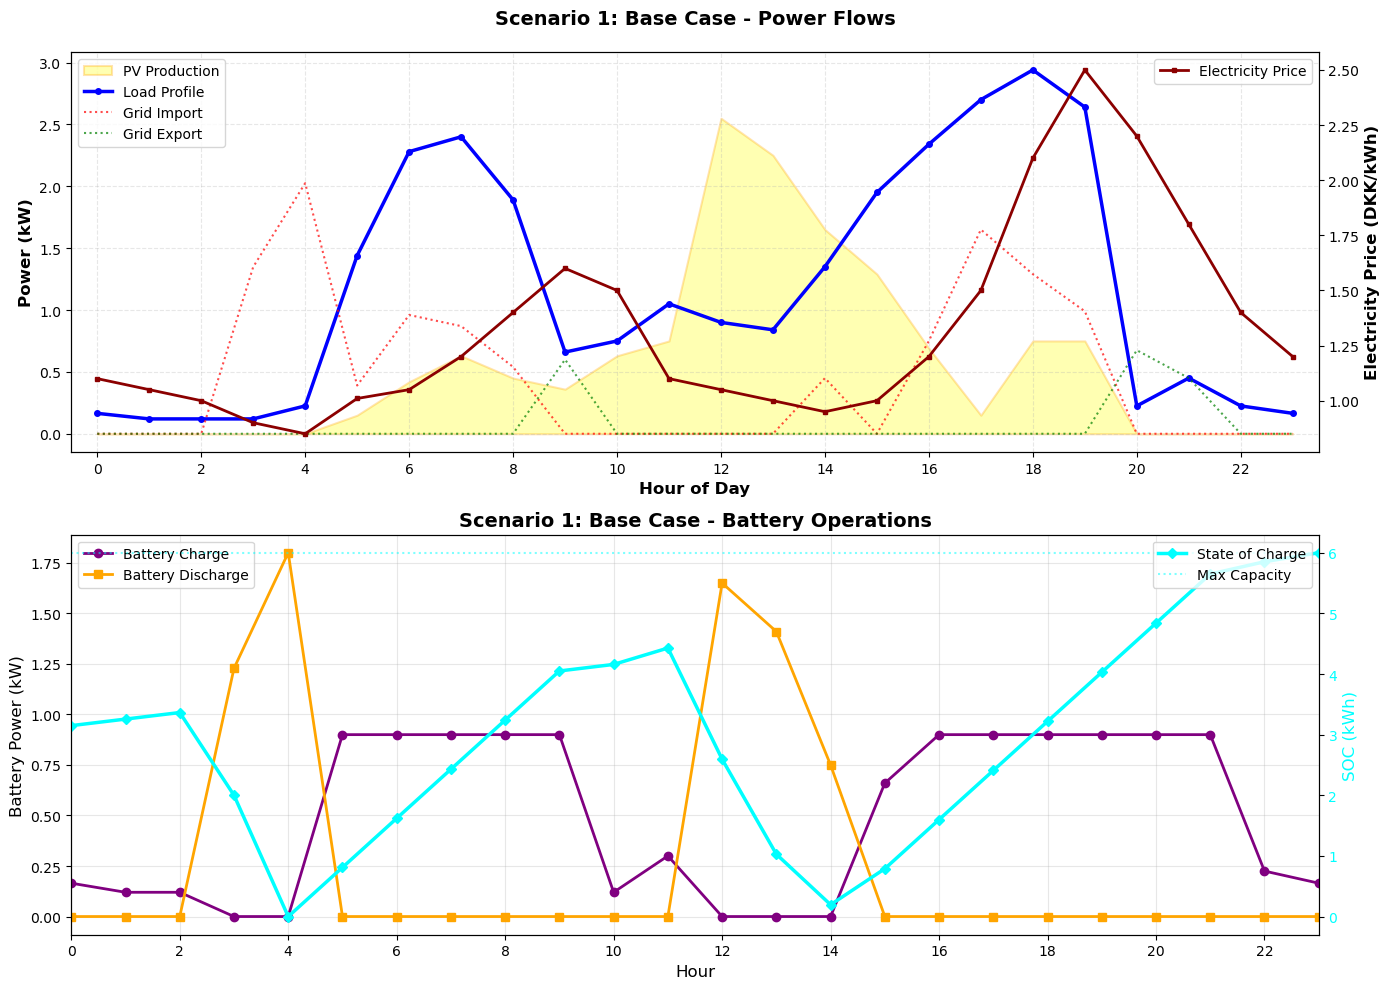

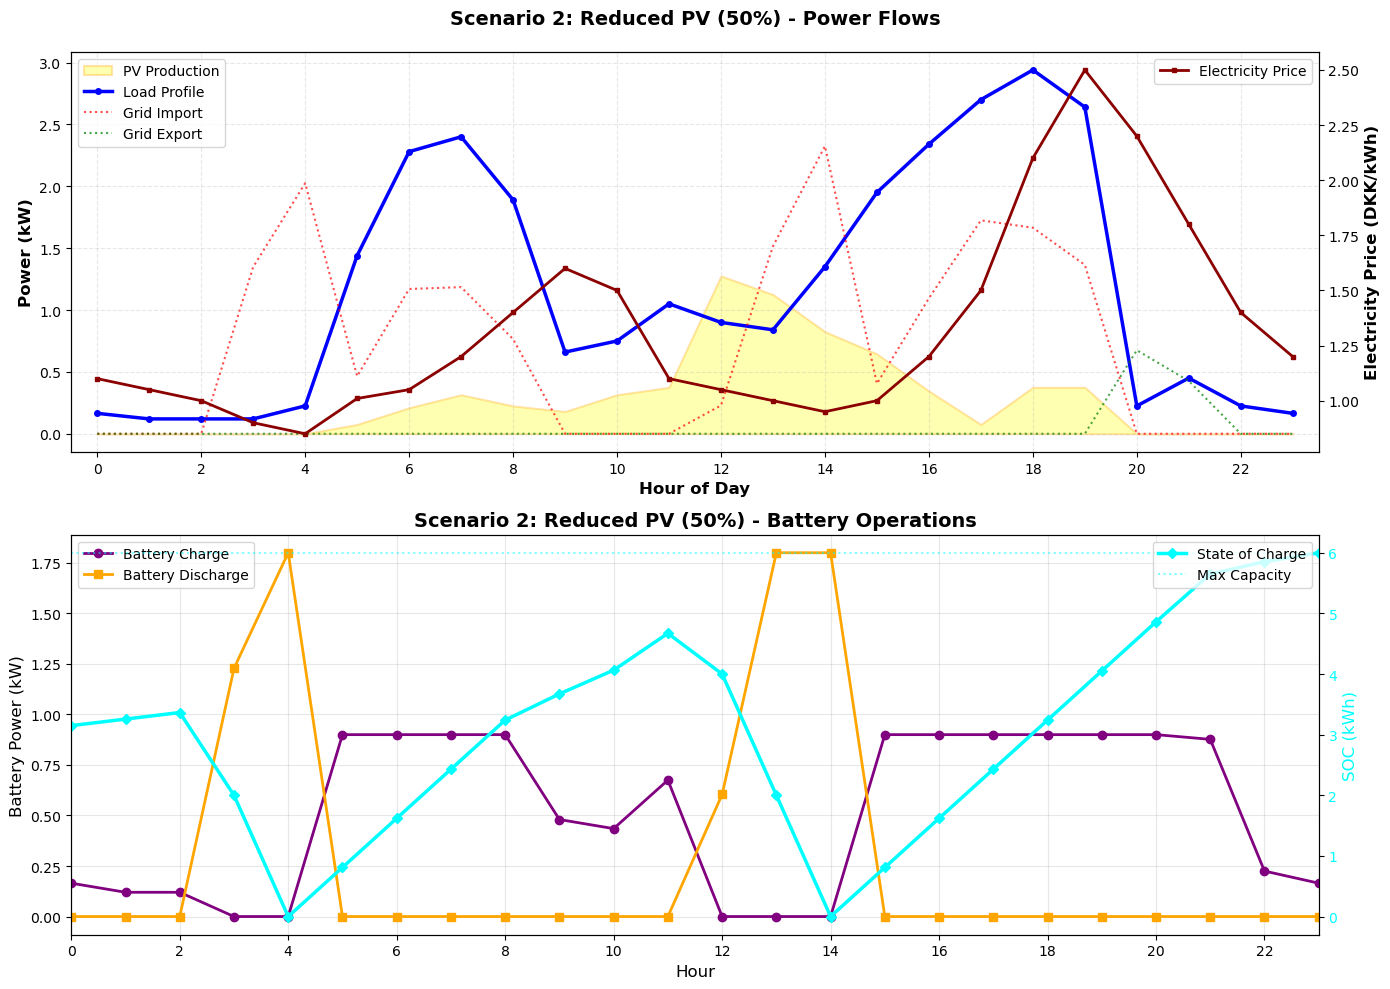

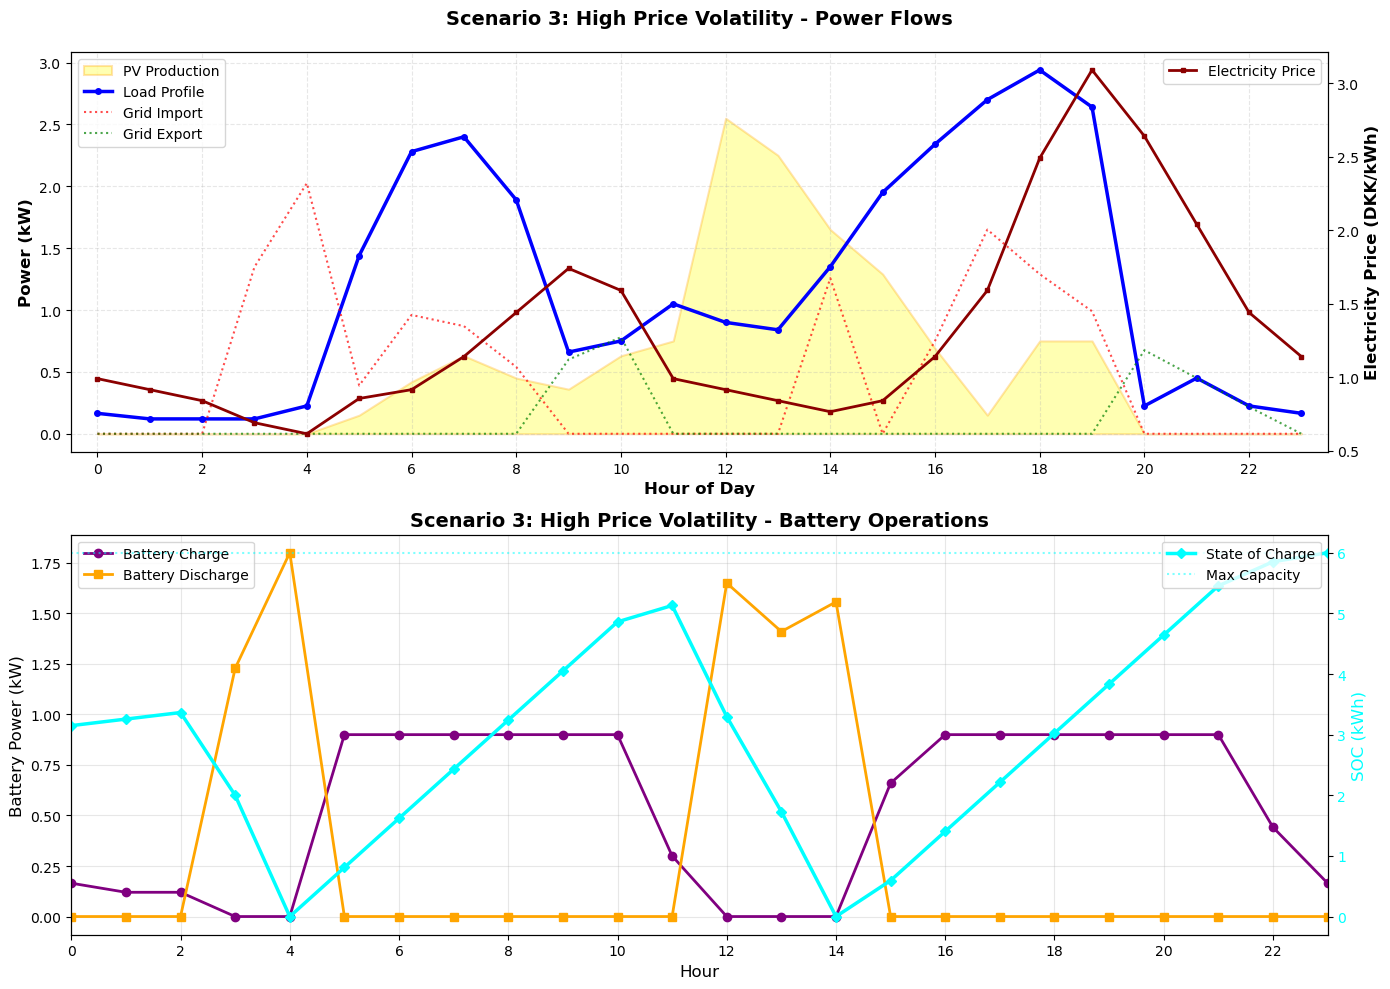

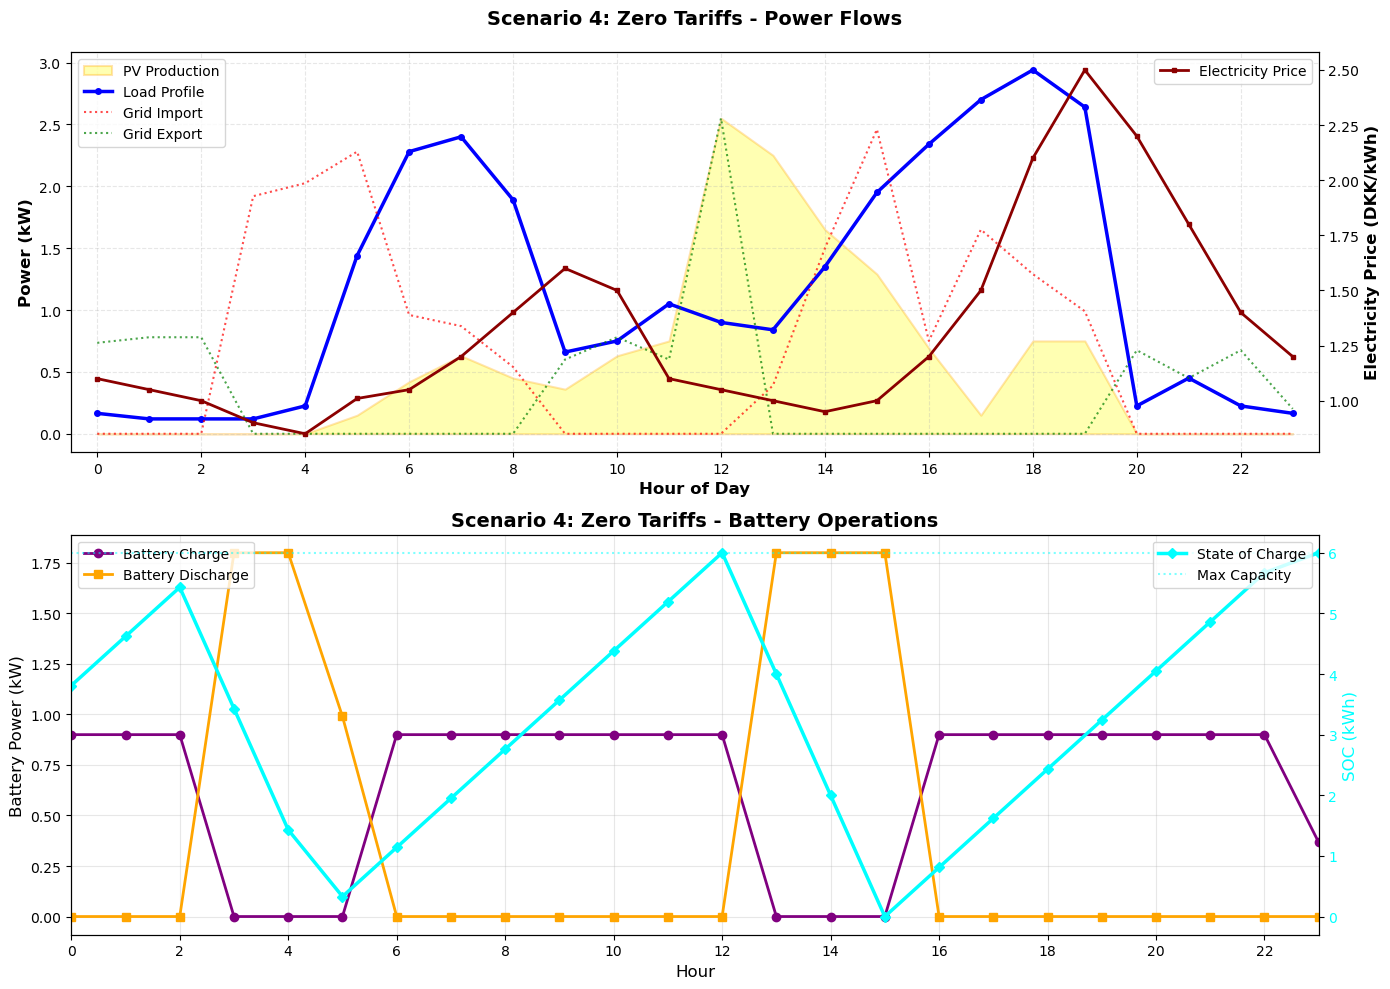

In [20]:
# Plot all 4 scenarios
plot_scenario_with_battery(scenario_1, pv_prod_hourly, electricity_prices, "Scenario 1: Base Case")
plot_scenario_with_battery(scenario_2, pv_reduced, electricity_prices, "Scenario 2: Reduced PV (50%)")
plot_scenario_with_battery(scenario_3, pv_prod_hourly, prices_volatile, "Scenario 3: High Price Volatility")
plot_scenario_with_battery(scenario_4, pv_prod_hourly, electricity_prices, "Scenario 4: Zero Tariffs")

## Alpha Sensitivity Analysis with Battery

**Objective**: Analyze cost-comfort trade-off with battery storage and compare to Part 1.B (no battery)

In [21]:
# Run alpha sensitivity with battery
alpha_values = [round(x * 0.2, 1) for x in range(0, 11)]  # 0.0, 0.2, 0.4, ..., 2.0

print("Running alpha sensitivity analysis WITH battery...")
alpha_results_with_battery = []

for alpha_val in alpha_values:
    result = run_scenario_with_battery(
        f"Alpha_{alpha_val}", pv_prod_hourly, electricity_prices, tau_imp, tau_exp, alpha_val, L_ref,
        max_import, max_export, L_max, Batt_cap, Batt_max_ch_power, Batt_max_dis_power,
        Batt_charging_eff, Batt_discharging_eff, Batt_initial_soc, Batt_final_soc
    )
    if result:
        alpha_results_with_battery.append({
            'alpha': alpha_val,
            'total_cost': result['total_cost'],
            'total_discomfort': result['total_discomfort']
        })

print(f"\n✓ Completed! Tested {len(alpha_results_with_battery)} alpha values.")
print("\nSummary (WITH Battery):")
print(f"{'Alpha':<10} {'Cost (DKK)':<15} {'Discomfort':<15}")
print("-" * 40)
for r in alpha_results_with_battery:
    print(f"{r['alpha']:<10} {r['total_cost']:<15.2f} {r['total_discomfort']:<15.2f}")

Running alpha sensitivity analysis WITH battery...

✓ Completed! Tested 11 alpha values.

Summary (WITH Battery):
Alpha      Cost (DKK)      Discomfort     
----------------------------------------
0.0        -20.87          41.00          
0.2        -20.87          27.95          
0.4        -20.87          27.95          
0.6        -20.87          27.95          
0.8        -16.47          21.66          
1.0        -14.40          19.50          
1.2        -9.95           15.47          
1.4        -6.51           12.74          
1.6        -1.89           9.62           
1.8        3.67            6.34           
2.0        8.40            3.93           

✓ Completed! Tested 11 alpha values.

Summary (WITH Battery):
Alpha      Cost (DKK)      Discomfort     
----------------------------------------
0.0        -20.87          41.00          
0.2        -20.87          27.95          
0.4        -20.87          27.95          
0.6        -20.87          27.95          
0.8       

### Plot 5: Alpha Sensitivity (Part 1.C WITH Battery)

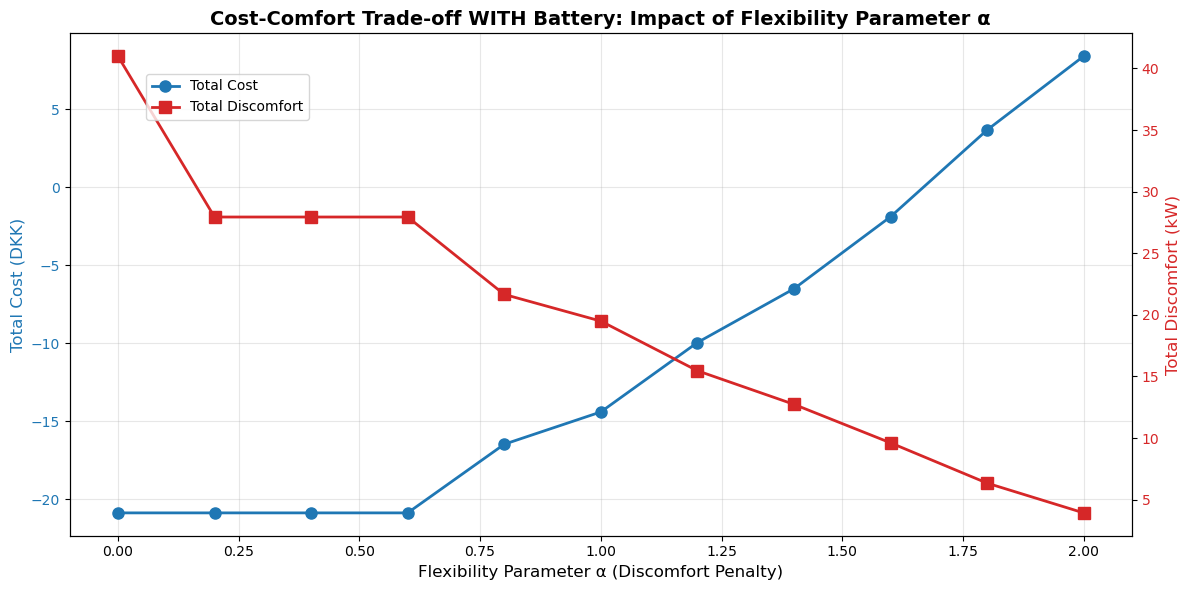


Key Insights (WITH Battery):
- Most flexible (α=0.0): Cost = -20.87 DKK, Discomfort = 41.00 kW
- Mid-range (α=1.0): Cost = -14.40 DKK, Discomfort = 19.50 kW
- Least flexible (α=2.0): Cost = 8.40 DKK, Discomfort = 3.93 kW


In [22]:
# Plot alpha sensitivity WITH battery (same format as Part 1.B)
fig, ax1 = plt.subplots(figsize=(12, 6))

alphas_c = [r['alpha'] for r in alpha_results_with_battery]
costs_c = [r['total_cost'] for r in alpha_results_with_battery]
discomforts_c = [r['total_discomfort'] for r in alpha_results_with_battery]

# Plot cost on left axis
color = 'tab:blue'
ax1.set_xlabel('Flexibility Parameter α (Discomfort Penalty)', fontsize=12)
ax1.set_ylabel('Total Cost (DKK)', color=color, fontsize=12)
ax1.plot(alphas_c, costs_c, marker='o', color=color, linewidth=2, markersize=8, label='Total Cost')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

# Plot discomfort on right axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Total Discomfort (kW)', color=color, fontsize=12)
ax2.plot(alphas_c, discomforts_c, marker='s', color=color, linewidth=2, markersize=8, label='Total Discomfort')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Cost-Comfort Trade-off WITH Battery: Impact of Flexibility Parameter α', fontsize=14, fontweight='bold')
fig.legend(loc='upper left', bbox_to_anchor=(0.12, 0.88), fontsize=10)
fig.tight_layout()
plt.show()

print("\nKey Insights (WITH Battery):")
print(f"- Most flexible (α={alphas_c[0]}): Cost = {costs_c[0]:.2f} DKK, Discomfort = {discomforts_c[0]:.2f} kW")
print(f"- Mid-range (α={alphas_c[len(alphas_c)//2]}): Cost = {costs_c[len(costs_c)//2]:.2f} DKK, Discomfort = {discomforts_c[len(discomforts_c)//2]:.2f} kW")
print(f"- Least flexible (α={alphas_c[-1]}): Cost = {costs_c[-1]:.2f} DKK, Discomfort = {discomforts_c[-1]:.2f} kW")

### Plot 6: Cost-Comfort Comparison (Part 1.B vs Part 1.C)

**Objective**: Show how battery storage shifts the Pareto frontier of cost-comfort trade-offs

⚠️ To complete this plot, copy alpha_results from Part 1.B
For now, plotting only Part 1.C results...



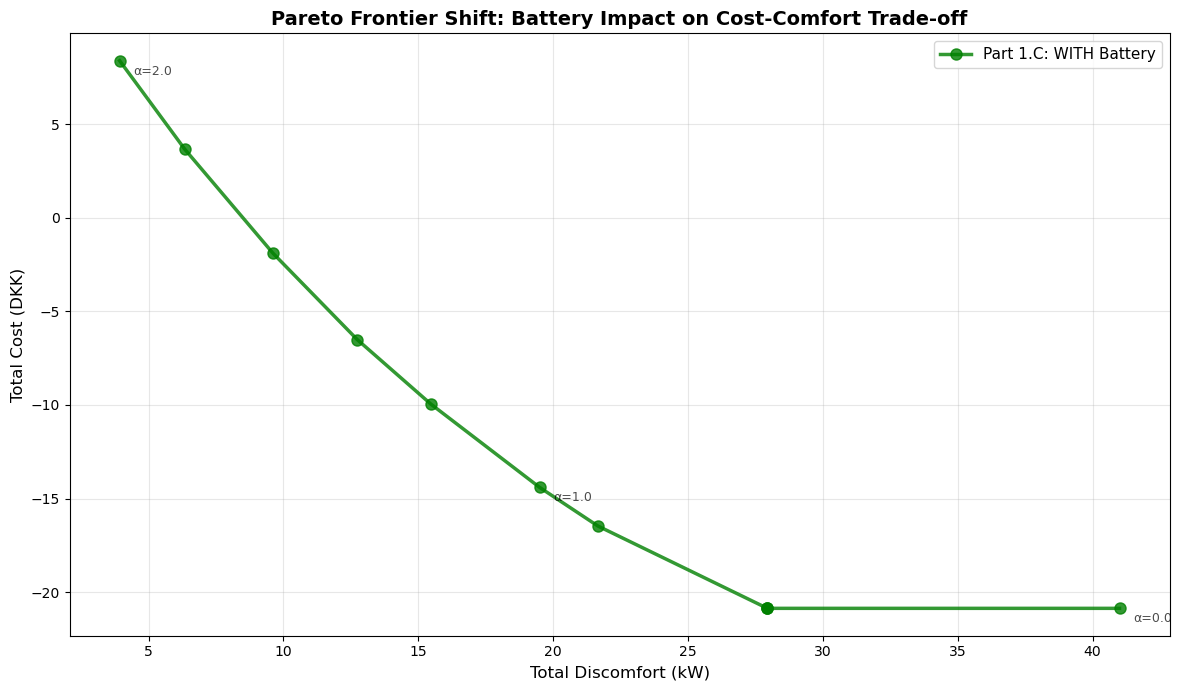


Interpretation:
- Lower curve = Better (lower cost for same discomfort)
- Battery shifts curve downward → cost savings across all flexibility levels
- Vertical distance = battery value at each flexibility level


In [23]:
# Load Part 1.B results for comparison
# NOTE: You need to run Part 1.B first to get alpha_results
# For now, we'll create placeholder data - replace with actual Part 1.B results

# Placeholder - replace these with actual Part 1.B results after running that notebook
print("⚠️ To complete this plot, copy alpha_results from Part 1.B")
print("For now, plotting only Part 1.C results...\n")

# If you have Part 1.B results, uncomment and modify:
# alphas_b = [r['alpha'] for r in alpha_results]  # From Part 1.B
# costs_b = [r['total_cost'] for r in alpha_results]
# discomforts_b = [r['total_discomfort'] for r in alpha_results]

# Plot comparison
fig, ax = plt.subplots(figsize=(12, 7))

# Part 1.C (WITH battery)
ax.plot(discomforts_c, costs_c, marker='o', color='green', linewidth=2.5, markersize=8, 
        label='Part 1.C: WITH Battery', alpha=0.8)

# Uncomment when you have Part 1.B data:
# ax.plot(discomforts_b, costs_b, marker='s', color='blue', linewidth=2.5, markersize=8, 
#         label='Part 1.B: WITHOUT Battery', alpha=0.8)

ax.set_xlabel('Total Discomfort (kW)', fontsize=12)
ax.set_ylabel('Total Cost (DKK)', fontsize=12)
ax.set_title('Pareto Frontier Shift: Battery Impact on Cost-Comfort Trade-off', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11, loc='upper right')

# Add annotations for key points
for i, alpha_val in enumerate(alphas_c):
    if alpha_val in [0.0, 1.0, 2.0]:  # Annotate key alpha values
        ax.annotate(f'α={alpha_val}', 
                   xy=(discomforts_c[i], costs_c[i]),
                   xytext=(10, -10), textcoords='offset points',
                   fontsize=9, alpha=0.7)

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- Lower curve = Better (lower cost for same discomfort)")
print("- Battery shifts curve downward → cost savings across all flexibility levels")
print("- Vertical distance = battery value at each flexibility level")

## Summary and Key Findings

### Battery Impact Across Scenarios:
1. **Base Case**: Battery provides arbitrage value through price-based charge/discharge
2. **Reduced PV**: Battery compensates for supply shortage by storing grid energy
3. **High Volatility**: Battery value increases with price spread
4. **Zero Tariffs**: Battery enables maximum arbitrage without tariff penalties

### Alpha Sensitivity Insights:
- Battery reduces cost across ALL flexibility levels (α values)
- Battery value is highest when load is inflexible (high α)
- Battery and load flexibility are complementary, not substitutes

### Model Validation:
- Check for simultaneous charge/discharge in results
- Verify SOC constraints satisfied (initial, final, bounds)
- Confirm energy balance across all hours